In [35]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, confusion_matrix
)
from xgboost import XGBClassifier


In [36]:
train_file = uproot.open(r"C:\Users\Agastya\OneDrive\Desktop\train_rooot_file.root")
test_file  = uproot.open(r"C:\Users\Agastya\OneDrive\Desktop\test_root_file.root")

print(train_file.keys())


['deepntuplizer;1', 'deepntuplizer/tree;42', 'deepntuplizer/tree;41']


In [37]:
train_tree = train_file["deepntuplizer/tree;42"]
test_tree = test_file["deepntuplizer/tree;42"]


In [38]:
file_path = r"C:\Users\Agastya\OneDrive\Desktop\train_rooot_file.root"

# open the file and tree
train_file = uproot.open(file_path)
print("Available keys in ROOT file:", train_file.keys())

# open the tree 
tree = train_file["deepntuplizer/tree"]
print("\nNumber of branches:", len(tree.keys()))
print("First 40 branches:\n", tree.keys()[:40])


Available keys in ROOT file: ['deepntuplizer;1', 'deepntuplizer/tree;42', 'deepntuplizer/tree;41']

Number of branches: 219
First 40 branches:
 ['Delta_gen_pt', 'event_no', 'gen_pt', 'isB', 'isBB', 'isC', 'isG', 'isLeptonicB', 'isLeptonicB_C', 'isS', 'isUD', 'isUndefined', 'jet_corr_pt', 'jet_eta', 'jet_looseId', 'jet_no', 'jet_phi', 'jet_pt', 'jet_tightId', 'npv', 'ntrueInt', 'pfBoostedDoubleSecondaryVertexAK8BJetTags', 'pfCombinedInclusiveSecondaryVertexV2BJetTags', 'pfCombinedMVAV2BJetTags', 'pfDeepCSVJetTags_probb', 'pfDeepCSVJetTags_probbb', 'pfDeepCSVJetTags_probc', 'pfDeepCSVJetTags_probcc', 'pfDeepCSVJetTags_probudsg', 'pfJetBProbabilityBJetTags', 'pfJetProbabilityBJetTags', 'rho', 'softPFElectronBJetTags', 'softPFMuonBJetTags', 'fj_doubleb', 'fj_eta', 'fj_gen_eta', 'fj_gen_pt', 'fj_isBB', 'fj_isH']


In [39]:

file_path = r"C:\Users\Agastya\OneDrive\Desktop\train_rooot_file.root"


tree = uproot.open(file_path)["deepntuplizer/tree"]

# Define features and label columns
feature_cols = ["jet_pt", "jet_eta", "jet_phi", "jet_corr_pt", "npv"]
label_cols = ["isB", "isBB", "isC", "isG", "isS", "isUD"]

# Load  into a DataFrame
data = tree.arrays(feature_cols + label_cols, library="pd")

# Derive a single label column
data["label"] = data[label_cols].idxmax(axis=1)  
data["label"] = data["label"].str.replace("is", "") 

# Drop rows without a valid label
data = data.dropna(subset=["label"])

print("Data loaded:", data.shape)
print("Classes:", data["label"].value_counts())
data.head()


Data loaded: (200000, 12)
Classes: label
G     62297
UD    59919
BB    32976
C     25179
B     10861
S      8768
Name: count, dtype: int64


,jet_pt,jet_eta,jet_phi,jet_corr_pt,npv,isB,isBB,isC,isG,isS,isUD,label
0,448.633636,-0.277724,-2.183877,448.633636,22.0,0,0,0,1,0,0,G
1,868.861389,-0.716812,2.365500,868.861389,15.0,0,0,0,1,0,0,G
2,573.674377,0.219193,0.296306,573.674377,18.0,0,0,0,1,0,0,G
3,206.318527,0.336462,2.244762,206.318527,14.0,0,0,0,1,0,0,G
4,1068.199097,0.889782,-2.385019,1068.199097,11.0,0,1,0,0,0,0,BB


In [40]:
train_path = r"C:\Users\Agastya\OneDrive\Desktop\train_rooot_file.root"
test_path  = r"C:\Users\Agastya\OneDrive\Desktop\test_root_file.root"

# Feature and label branches
feature_cols = ["jet_pt", "jet_eta", "jet_phi", "jet_corr_pt", "npv"]
label_cols = ["isB", "isBB", "isC", "isG", "isS", "isUD"]

def load_root_dataset(path):
    tree = uproot.open(path)["deepntuplizer/tree"]
    df = tree.arrays(feature_cols + label_cols, library="pd")
    df["label"] = df[label_cols].idxmax(axis=1).str.replace("is", "")
    df = df.dropna(subset=["label"])
    return df

train_df = load_root_dataset(train_path)
test_df = load_root_dataset(test_path)

print(" Train:", train_df.shape)
print(" Test:", test_df.shape)
print("Classes (train):\n", train_df["label"].value_counts())


 Train: (200000, 12)
 Test: (200000, 12)
Classes (train):
 label
G     62297
UD    59919
BB    32976
C     25179
B     10861
S      8768
Name: count, dtype: int64


In [41]:
def add_physics_features(df):
    df["pt_over_eta"] = df["jet_pt"] / (abs(df["jet_eta"]) + 1e-6)
    df["log_pt"] = np.log(df["jet_pt"] + 1)
    df["corr_ratio"] = df["jet_corr_pt"] / (df["jet_pt"] + 1e-6)
    df["phi_eta_product"] = df["jet_phi"] * df["jet_eta"]
    return df

train_df = add_physics_features(train_df)
test_df = add_physics_features(test_df)


In [42]:
feature_cols_extended = feature_cols + ["pt_over_eta", "log_pt", "corr_ratio", "phi_eta_product"]

X_train = train_df[feature_cols_extended]
y_train = train_df["label"]
X_test = test_df[feature_cols_extended]
y_test = test_df["label"]


In [43]:
# Define the feature columns 
feature_cols = ["jet_pt", "jet_eta", "jet_phi", "jet_corr_pt", "npv"]

# Define the label column 
y_train = train_df["label"]
y_test  = test_df["label"]

# Extract features
X_train = train_df[feature_cols]
X_test  = test_df[feature_cols]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [44]:
from sklearn.preprocessing import LabelEncoder

# Encoding the string labels 
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


Label mapping: {'B': 0, 'BB': 1, 'C': 2, 'G': 3, 'S': 4, 'UD': 5}


✅ Model trained successfully!

=== Classification Report ===
              precision    recall  f1-score   support

           B       0.12      0.00      0.00     10668
          BB       0.35      0.30      0.33     33127
           C       0.30      0.00      0.00     24813
           G       0.37      0.61      0.46     62538
           S       0.00      0.00      0.00      8642
          UD       0.42      0.48      0.45     60212

    accuracy                           0.38    200000
   macro avg       0.26      0.23      0.21    200000
weighted avg       0.34      0.38      0.33    200000



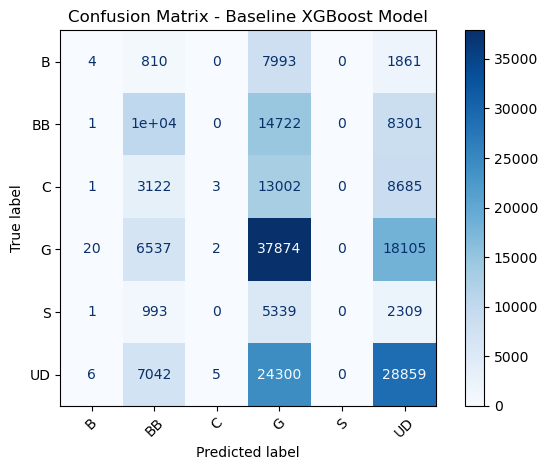

In [45]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Model Definition
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Model Training
xgb.fit(X_train_scaled, y_train_encoded)

#Predictions
y_pred_encoded = xgb.predict(X_test_scaled)
y_pred = le.inverse_transform(y_pred_encoded)

print("✅ Model trained successfully!")

# Evaluation
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, zero_division=0))  # avoids UndefinedMetricWarning

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Baseline XGBoost Model")
plt.grid(False)
plt.tight_layout()
plt.show()


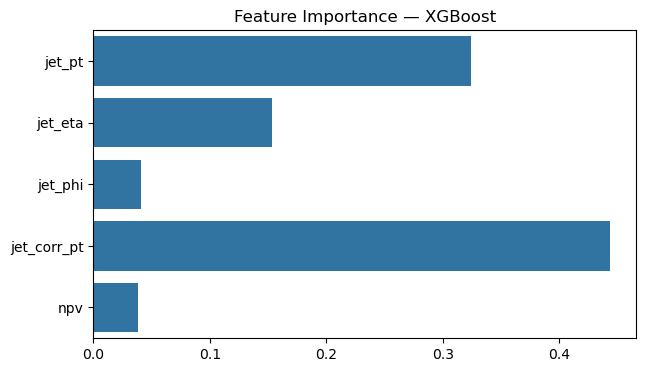

In [46]:
importances = xgb.feature_importances_
plt.figure(figsize=(7, 4))
sns.barplot(x=importances, y=feature_cols)
plt.title("Feature Importance — XGBoost")
plt.show()


In [47]:
# Predict probabilities for each class
y_proba = xgb.predict_proba(X_test_scaled)


In [48]:
# For binary classification 
y_score = y_proba[:, 1]  # probability of class 1 


In [49]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)


In [50]:
from sklearn.metrics import roc_curve, auc, roc_auc_score


In [51]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(lb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


In [52]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(lb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(lb.classes_))]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(len(lb.classes_)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= len(lb.classes_)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


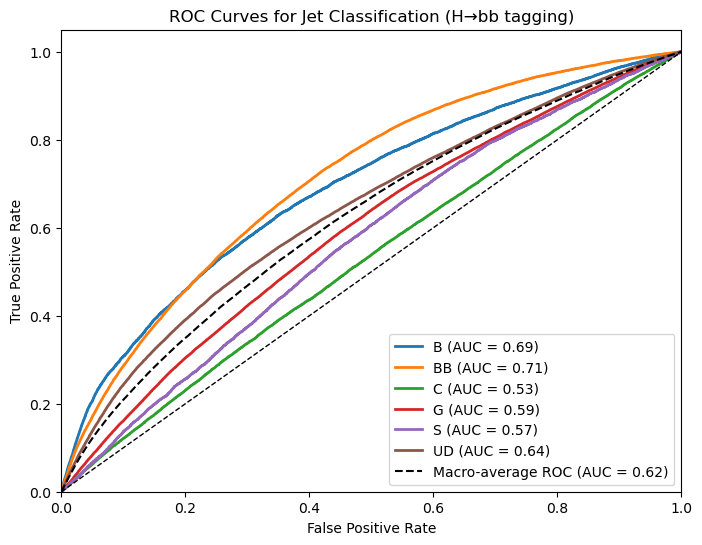

In [53]:
plt.figure(figsize=(8, 6))

# Plot each class ROC
for i, class_name in enumerate(lb.classes_):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_name} (AUC = {roc_auc[i]:.2f})")

# Plot macro-average
plt.plot(fpr["macro"], tpr["macro"], color='black', linestyle='--',
         label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Jet Classification (H→bb tagging)')
plt.legend(loc="lower right")
plt.show()
